This is not original at all!!
Data Munging: https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series (Please Upvote!)
LSTM: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru (Please Upvote!)

In [1]:
# BASIC IDEA OF THE KERNEL

# The data consists of a one dimensional time series x with 600 Mio data points. 
# At test time, we will see a time series of length 150'000 to predict the next earthquake.
# The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
# features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
# time steps. 

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, Dropout, TimeDistributed, LSTM, CuDNNLSTM
from keras.optimizers import adam, RMSprop
from keras.callbacks import ModelCheckpoint
# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
float_data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:]),
                 extract_features(temp[:, -step_length // 300:])]

# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
    
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)

Using TensorFlow backend.


Our RNN is based on 16 features


In [2]:
n_features

16

In [3]:
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=(None,n_features)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(CuDNNLSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(CuDNNLSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(CuDNNLSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN


model.summary()

# Compile and fit model
model.compile(optimizer='rmsprop', loss='mae')



history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=32,
                              verbose=2,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200
                             )





Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 50)          13600     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, None, 50)          20400     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, None, 50)          20400     
_________________________________________________________________
dropout_3 (Dropout)  

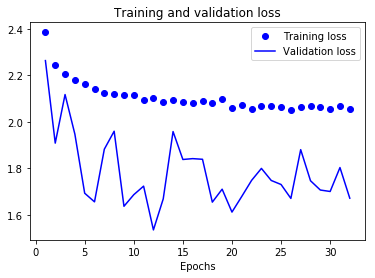

In [4]:
# Visualize accuracies
import matplotlib.pyplot as plt
%matplotlib inline
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None
perf_plot(history) # Extra Layer

In [5]:
# Load submission file
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
x = None
# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values[:]
    #print(x.shape)
    submission.time_to_failure[i] = (model.predict(np.expand_dims(create_X(x), 0)))

# Save
submission.to_csv('submission.csv')

100%|██████████| 2624/2624 [01:09<00:00, 37.76it/s]


In [6]:
submission.head(10)

,time_to_failure
seg_id,
seg_00030f,2.936813
seg_0012b5,5.065711
seg_00184e,5.618876
seg_003339,8.171511
seg_0042cc,7.168787
seg_004314,1.702372
seg_004cd2,7.831118
seg_004ee5,5.194794
seg_004f1f,4.886782
